## Experiment size
- baseline
- minimum detectable effect
- alpha: type I error
- beta: type II error

>> reference: https://zhuanlan.zhihu.com/p/40919260

### Experiment size

In [9]:
import numpy as np
import scipy.stats as stats
def experiment_size(p_null, p_alt, alpha = .05, beta = .20):
    """
    Compute the minimum number of samples needed to achieve a desired power
    level for a given effect size.
    
    Input parameters:
        p_null: base success rate under null hypothesis
        p_alt : desired success rate to be detected
        alpha : Type-I error rate
        beta  : Type-II error rate
    
    Output value:
        n : Number of samples required for each group to obtain desired power
    """
    
    # Get necessary z-scores and standard deviations (@ 1 obs per group)
    z_null = stats.norm.ppf(1 - alpha)
    z_alt  = stats.norm.ppf(beta)
    sd_null = np.sqrt((p_null * (1-p_null) + p_null * (1-p_null)))
    sd_alt  = np.sqrt(p_null * (1-p_null) + p_alt  * (1-p_alt) )
    
    # Compute and return minimum sample size
    p_diff = p_alt - p_null
    n = ((z_null * sd_null - z_alt * sd_alt)/p_diff)**2
    return np.ceil(n)

Let's say that we want to detect an increase of 50 downloads per day (up to 570 per day, or a .175 rate). How many days of data would we need to collect in order to get enough visitors to detect this new rate at an overall 5% Type I error rate and at 80% power?

In [7]:
experiment_size(0.16, 0.175, alpha = 0.025) * 2/3250

5.834461538461539

What if we wanted to detect an increase of 10 license purchases per day (up to 75 per day, or a .023 rate). How many days of data would we need to collect in order to get enough visitors to detect this new rate at an overall 5% Type I error rate and at 80% power?

In [8]:
experiment_size(0.02, 0.023, alpha = 0.025) *2/3250

21.495384615384616

### Analyze data

#### Invariant metric
>> There should be no difference in assigned sample size between control and experiment group
>> **H0: number of control = number of experiment**

In [18]:
import os
os.chdir('C:\\Users\\juanx\\delicious\\DS\\udacity_data_scientist\\statistical_consideration_in_testing\\homepage-experiment-data')

In [19]:
os.listdir()

['homepage-experiment-data.csv']

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [20]:
df = pd.read_csv('homepage-experiment-data.csv')

In [21]:
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3


In [24]:
n_ctr = df['Control Cookies'].sum()
n_exp = df['Experiment Cookies'].sum()
n_total = n_ctr + n_exp

In [23]:
print('experiment size is {}, control size is {}'.format(n_exp, n_ctr))

experiment size is 47346, control size is 46851


In [27]:
# simulation split of half half 200000 times
n_simu = np.random.binomial(n_total, 0.5, 200000)

# p value of 2 sided experiment
print('p value is {}'.format(np.logical_or(n_simu <= n_ctr, n_simu >= (n_total - n_ctr)).mean()))

p value is 0.106915


In [28]:
print('Cannot reject H0, invariant metric passed')

Cannot reject H0, invariant metric passed


#### Evaluation metrics

##### Download rate
>> **H0: old page >= new page**

In [48]:
def evaluation_homepage(metric_control, metric_exp, baseline_control, baseline_exp, simulation_size):
    """
    Compute p value for evaluation metrics
    
    Input parameters:
        metric_control: denominator defined_metric of control group - str
        metric_exp: denominator defined_metric of experiment group - str
        baseline_control: numerator defined_metric of control group - str
        baseline_exp: numerator defined_metric of experiment group - str
        simulation_size: simulation size - int
    
    Output value:
        calculated p value: str
        plot: visualized distribution
    """
    
    n_ctr = df[baseline_control].sum()
    n_exp = df[baseline_exp].sum()
    n_total = n_ctr + n_exp
    exp_click = df[metric_exp].sum()/n_exp
    ctr_click = df[metric_control].sum()/n_ctr
    estimator = (df[metric_control].sum() + df[metric_exp].sum())/n_total
    
    # simulation
    exp_simu = np.random.binomial(n_exp, estimator, simulation_size)
    ctr_simu = np.random.binomial(n_ctr, estimator, simulation_size)
    
    simu_diffs = exp_simu/n_exp - ctr_simu/n_ctr
    
    # plot
    actual_diff = exp_click - ctr_click
    plt.hist(simu_diffs)
    plt.axvline(actual_diff, color='red', label='observed_diff')
    plt.title('Simulated distribution of p_diffs')
    plt.xlabel('simu_diffs')
    plt.ylabel('count')
    plt.legend()
    
    # p value
    p_value = (simu_diffs > actual_diff).mean()
    print('p_value is {}'.format(p_value))

p_value is 0.0


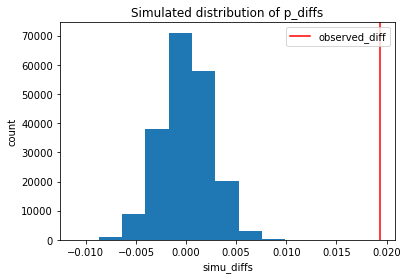

In [49]:
evaluation_homepage('Control Downloads', 'Experiment Downloads', 'Control Cookies', 'Experiment Cookies', 200000)

p_value is 0.35259


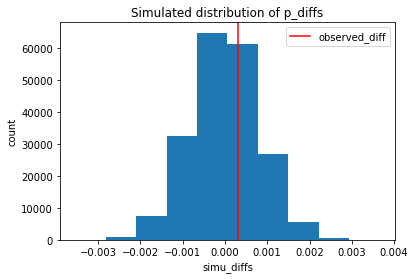

In [50]:
evaluation_homepage('Control Licenses', 'Experiment Licenses','Control Cookies', 'Experiment Cookies', 200000)